## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.2]
redice_lr_patient = [5, 10]

In [8]:
import itertools
from keras.callbacks import ReduceLROnPlateau

results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0804 21:20:17.750855 16164 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 21:20:17.751852 16164 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 21:20:17.754847 16164 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 21:20:17.889536 16164 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0804 21:20:18.087812 16164 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0804 21:20:18.097752 16164 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0804 21:20:18.196995 16164 deprecation.py:323] From D:\Software\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 3s 57us/step - loss: 1.3637 - acc: 0.5243 - val_loss: 1.5393 - val_acc: 0.4572
Epoch 14/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.3428 - acc: 0.5326 - val_loss: 1.5311 - val_acc: 0.4585
Epoch 15/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.3238 - acc: 0.5391 - val_loss: 1.5210 - val_acc: 0.4666
Epoch 16/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.3056 - acc: 0.5460 - val_loss: 1.5159 - val_acc: 0.4669
Epoch 17/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2872 - acc: 0.5516 - val_loss: 1.5076 - val_acc: 0.4683
Epoch 18/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2696 - acc: 0.5587 - val_loss: 1.5048 - val_acc: 0.4715
Epoch 19/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2542 - acc: 0.5636 - val_loss: 1.5002 - val_acc: 0.4705
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 4s 83us/step - loss: 2.3758 - acc: 0.2288 - val_loss: 2.2065 - val_acc: 0.2772
Epoch 2/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.8846 - acc: 0.3465 - val_loss: 1.9123 - val_acc: 0.3459
Epoch 3/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.7405 - acc: 0.3907 - val_loss: 1.7724 - val_acc: 0.3815
Epoch 4/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.6613 - acc: 0.4161 - val_loss: 1.7244 - val_acc: 0.4004
Epoch 5/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.6060 - acc: 0.4383 - val_loss: 1.6821 - val_acc: 0.4079
Epoch 6/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.5618 - acc: 0.4530 - val_loss: 1.6511 - val_acc: 0.4212
Epoch 7/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5257 - acc: 0.4658 - val_loss: 1.6359 - val_acc: 0.4238
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 3s 59us/step - loss: 0.4549 - acc: 0.8635 - val_loss: 1.6484 - val_acc: 0.5043
Epoch 24/25
50000/50000 [==============================] - 3s 59us/step - loss: 0.4317 - acc: 0.8728 - val_loss: 1.6054 - val_acc: 0.5112

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 25/25
50000/50000 [==============================] - 3s 59us/step - loss: 0.3820 - acc: 0.8973 - val_loss: 1.5677 - val_acc: 0.5276
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048   

50000/50000 [==============================] - 3s 60us/step - loss: 1.1335 - acc: 0.6131 - val_loss: 1.4691 - val_acc: 0.4777
Epoch 10/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.1015 - acc: 0.6234 - val_loss: 1.4296 - val_acc: 0.4962
Epoch 11/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.0716 - acc: 0.6357 - val_loss: 1.4336 - val_acc: 0.4946
Epoch 12/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.0399 - acc: 0.6472 - val_loss: 1.4388 - val_acc: 0.4921
Epoch 13/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.0137 - acc: 0.6594 - val_loss: 1.4619 - val_acc: 0.4846
Epoch 14/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.9897 - acc: 0.6677 - val_loss: 1.4374 - val_acc: 0.4980
Epoch 15/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.9618 - acc: 0.6773 - val_loss: 1.4466 - val_acc: 0.4951

Epoch 00015: ReduceLROnPlateau reducing learn

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.8096 - acc: 0.3732 - val_loss: 1.9977 - val_acc: 0.3376
Epoch 2/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.5477 - acc: 0.4532 - val_loss: 2.0300 - val_acc: 0.3263
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4437 - acc: 0.4901 - val_loss: 2.3136 - val_acc: 0.2836
Epoch 4/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3608 - acc: 0.5209 - val_loss: 2.6667 - val_acc: 0.2636
Epoch 5/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3071 - acc: 0.5377 - val_loss: 1.9816 - val_acc: 0.3421
Epoch 6/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.2584 - acc: 0.5546 - val_loss: 2.2289 - val_acc: 0.3047
Epoch 7/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.2067 - acc: 0.5741 - val_loss: 1.8813 - val_acc

50000/50000 [==============================] - 3s 55us/step - loss: 0.6777 - acc: 0.7757 - val_loss: 2.0020 - val_acc: 0.4113

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.5780 - acc: 0.8203 - val_loss: 1.5489 - val_acc: 0.4988
Epoch 25/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.5472 - acc: 0.8346 - val_loss: 1.6388 - val_acc: 0.4811
Numbers of exp: 10, reduce_factor: 0.20, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048   

Epoch 9/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.8401 - acc: 0.3631 - val_loss: 1.9017 - val_acc: 0.3444
Epoch 10/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.8095 - acc: 0.3730 - val_loss: 1.8724 - val_acc: 0.3541
Epoch 11/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.7823 - acc: 0.3831 - val_loss: 1.8471 - val_acc: 0.3596
Epoch 12/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.7577 - acc: 0.3914 - val_loss: 1.8297 - val_acc: 0.3693
Epoch 13/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.7348 - acc: 0.3984 - val_loss: 1.8074 - val_acc: 0.3723
Epoch 14/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.7150 - acc: 0.4055 - val_loss: 1.7912 - val_acc: 0.3786
Epoch 15/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.6957 - acc: 0.4126 - val_loss: 1.7766 - val_acc: 0.3829
Epoch 16/25
50000/50000 [==========

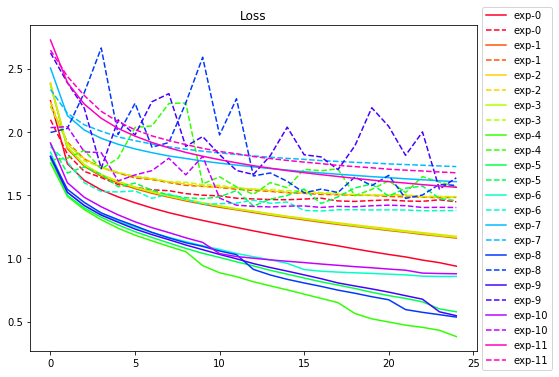

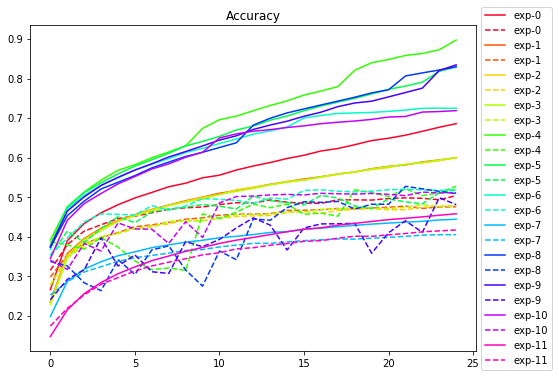

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()